# Sequential Parameter Optimization
## `river` Hyperparameter Tuning: SNARIMAX

In [1]:
pip list | grep spotPython

spotPython                                    0.17.0
spotRiver                               0.0.2
spotPythonstream                              0.1.15.dev4+g96550c7
Note: you may need to restart the kernel to use updated packages.


In [2]:
# import sys
# !{sys.executable} -m pip install --upgrade build
# !{sys.executable} -m pip install --upgrade --force-reinstall http://www.gm.fh-koeln.de/~bartz/site/spotPython.tar.gz

## Example 1: SNARIMAX Hyperparameter

In [3]:
import numpy as np
from math import inf
from spotRiver.fun.hyperriver import HyperRiver
from spotPython.spot import spot
from spotRiver import data
from scipy.optimize import shgo
from scipy.optimize import direct
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

### 1 The Objective Function 

* Here we will use the river `SNARIMAX` function.
* First, the function will be tested independently from `Spot`.

In [4]:
import datetime as dt
from river import datasets
from river import time_series
from river import utils
import calendar
import math
from river import compose
from river import linear_model
from river import optim
from river import preprocessing
from river import metrics

horizon = 12
future = [
     {'month': dt.date(year=1961, month=m, day=1)}
     for m in range(1, horizon + 1)
]

def get_month_distances(x):
     return {
         calendar.month_name[month]: math.exp(-(x['month'].month - month) ** 2)
         for month in range(1, 13)
     }

def get_ordinal_date(x):
    return {'ordinal_date': x['month'].toordinal()}

extract_features = compose.TransformerUnion(
    get_ordinal_date,
    get_month_distances
)

model = (
    extract_features |
    time_series.SNARIMAX(
        p=1,
        d=0,
        q=0,
        m=12,
        sp=3,
        sq=6,
        regressor=(
            preprocessing.StandardScaler() |
            linear_model.LinearRegression(
                intercept_init=110,
                optimizer=optim.SGD(0.01),
                intercept_lr=0.3
            )
        )
    )
)
metric = metrics.MAE()
dataset = datasets.AirlinePassengers()
res = time_series.evaluate(
     dataset,
     model,
     metric,
     horizon=12
)
y = res.metrics
z = 0.0
for i in range(len(y)):
        z = z + y[i].get()
z

276.0807503236645

### 2 The `fun_snarimax` from `spotPython`'s `HyperRiver` class

* Next, we use the implementation of the function from the `HyperRiver` class.
* Twelve hyperparameters to be optimized. Here:

0. `p` (int):
    Order of the autoregressive part.
    This is the number of past target values that will be included as features.
1. `d` (int):
    Differencing order.
2. `q` (int):
    Order of the moving average part.
    This is the number of past error terms that will be included as features.
3. `m` (int):
    Season length used for extracting seasonal features.
    If you believe your data has a seasonal pattern, then set this accordingly.
    For instance, if the data seems to exhibit a yearly seasonality,
    and that your data is spaced by month, then you should set this to `12`.
    Note that for this parameter to have any impact you should also set
    at least one of the `p`, `d`, and `q` parameters.
4. `sp` (int):
    Seasonal order of the autoregressive part.
    This is the number of past target values that will be included as features.
5. `sd` (int):
    Seasonal differencing order.
6. `sq`(int):
    Seasonal order of the moving average part.
    This is the number of past error terms that will be included as features.
7. `lr` (float):
    learn rate of the linear regression model. A river `preprocessing.StandardScaler`
    piped with a river `linear_model.LinearRegression` will be used.
8. `intercept_lr` (float): intercept of the the linear regression model.
    A river `preprocessing.StandardScaler` piped with a river `linear_model.LinearRegression`
    will be used.
9. `hour` (bool): If `True`, an hourly component is added.
10. `weekday` (bool): If `True`, an weekday component is added.
11. `month` (bool): If `True`, an monthly component is added.

In [5]:
from spotRiver.fun.hyperriver import HyperRiver
fun = HyperRiver(123).fun_snarimax
var_type = ["int"] * 7 + ["num", "num"] + ["factor"] * 3

In [6]:
from spotRiver.data import AirlinePassengers
dataset = AirlinePassengers()
#                 p, d, q, m, sp, sd, sq, lr, intercept_lr, hour, weekday, month:
lower = np.array([0, 0, 0, 1, 0,  0,  0,   0.00225, 0.05,   0,        0,   0])
upper = np.array([1, 1, 1, 24, 1,  1,   1,  0.0025, 0.1,    0,        0,   1])
fun_control = {"horizon": 12,
               "grace_period": None,
               "data": dataset,
               }

In [7]:
GW = False
if GW:
    from spotPython.data import GW
    dataset = GW()
    #                 p, d, q, m, sp, sd, sq, lr, intercept_lr, , hour, weekday, month:
    lower = np.array([0, 0, 0, 12, 0,  0,  0,   0.00225, 0.05,   0,        0,   0])
    upper = np.array([0, 0, 0, 24, 0,  0,   0,  0.0025, 0.1,     1,        1,   1])
    fun_control = {"horizon": 24,
                "data": dataset}

### 3 Run the `Spot` Optimizer

In [8]:
spot_snarimax = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = 2,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type=var_type,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": 10,
                                   "repeats": 1},
                   surrogate_control={"noise": False,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": 12,
                                      "model_optimizer": differential_evolution,
                                      "model_fun_evals": 1000,
                                      })
spot_snarimax.run()

spotPython tuning: [##########] 100.00% Done...


### 4 Results 

* Print the Results

In [9]:
spot_snarimax.print_results()

min y: 18.133995698734996
min X: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 1.1000000e+01 0.0000000e+00
  1.0000000e+00 1.0000000e+00 2.2500000e-03 8.9115336e-02 0.0000000e+00
  0.0000000e+00 1.0000000e+00]]


* Show the Progress

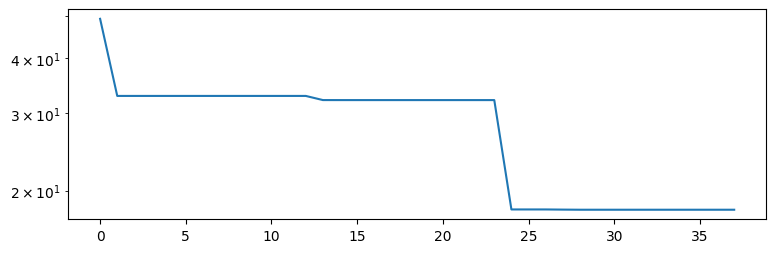

In [10]:
spot_snarimax.plot_progress(log_y=True)

In [11]:
spot_snarimax.print_importance()

Importance relative to the most important parameter:
Parameter 0 :  1.0217640000444723
Parameter 1 :  4.362336410650256e-05
Parameter 2 :  0.02742110092478002
Parameter 3 :  44.21817773417936
Parameter 4 :  3.9981487809568444e-05
Parameter 5 :  100.0
Parameter 6 :  1.7417739150903674e-05
Parameter 7 :  1.4968380431952743e-05
Parameter 8 :  0.0011906969128783551
Parameter 9 :  0.007057970880548016


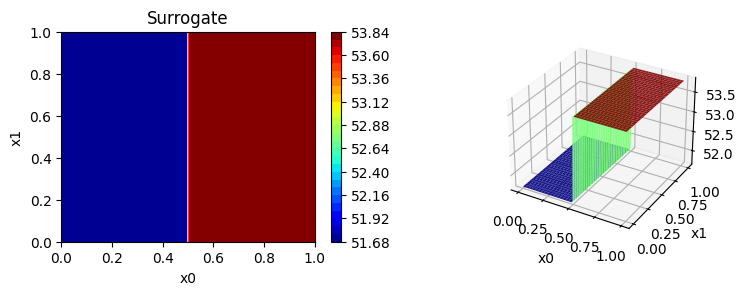

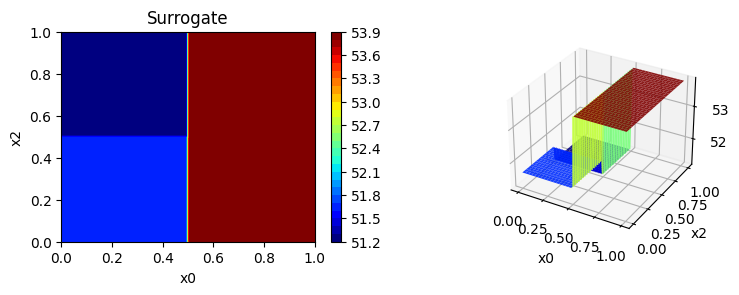

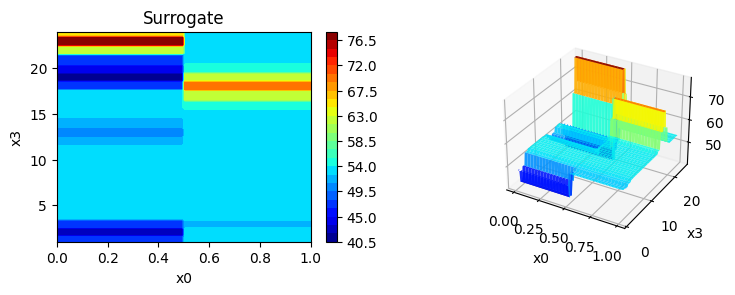

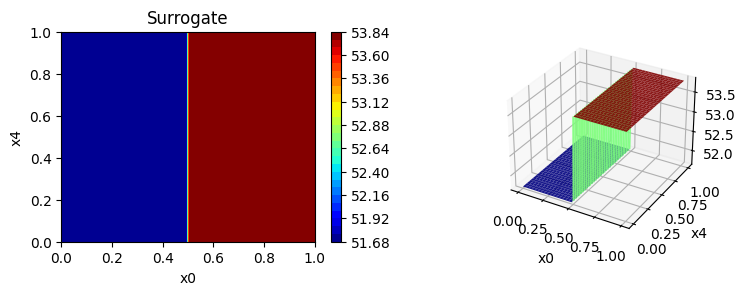

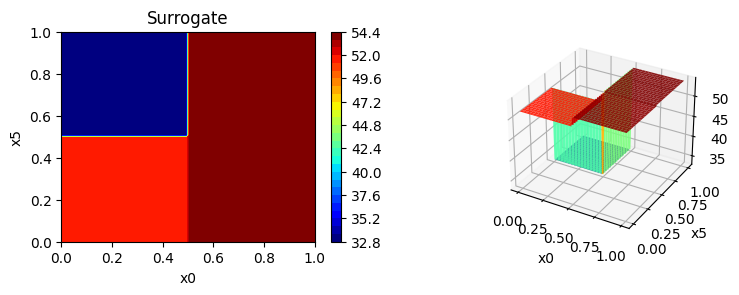

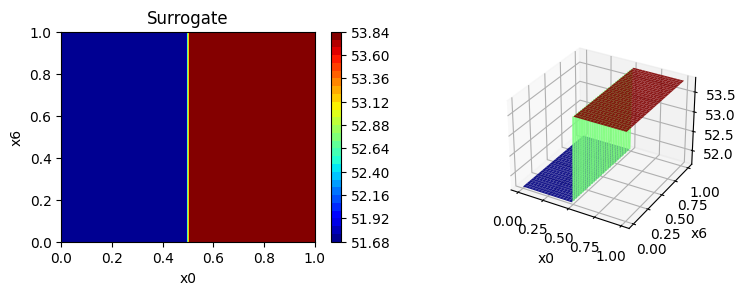

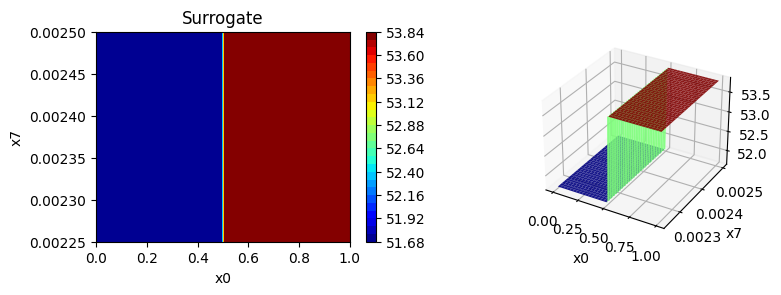

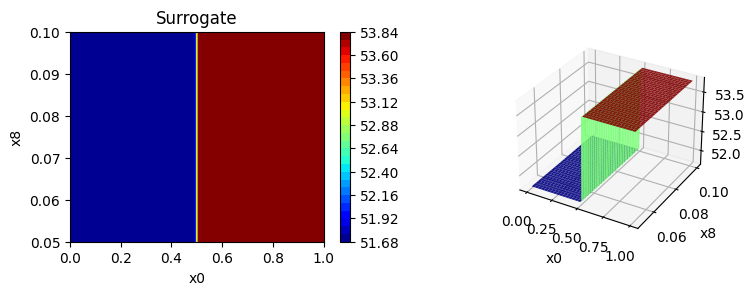

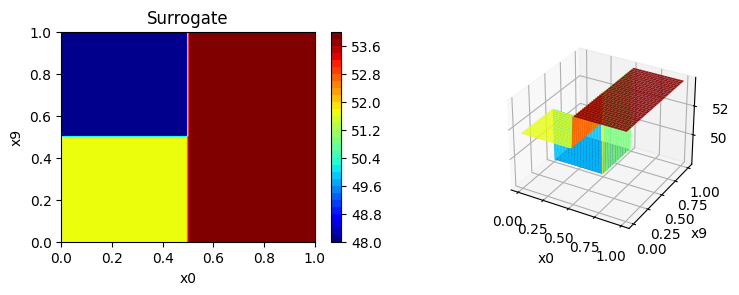

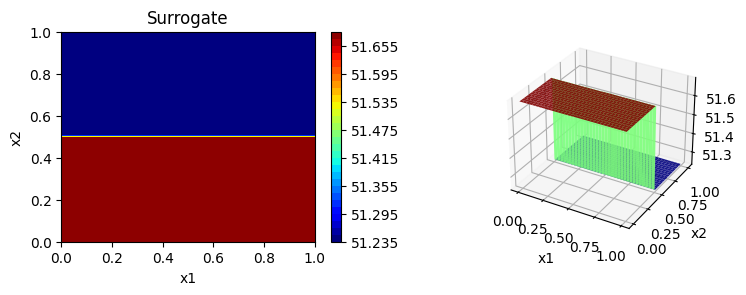

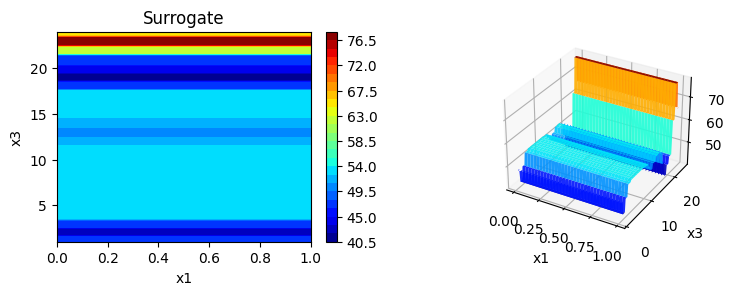

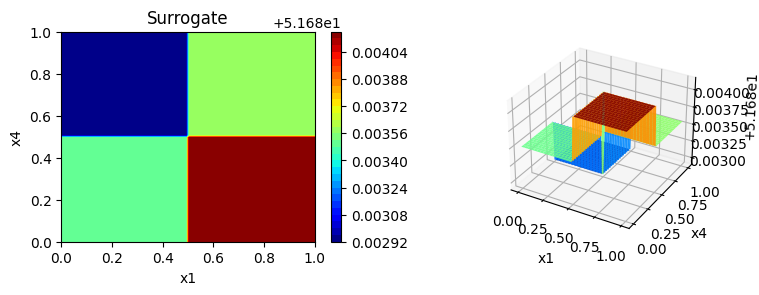

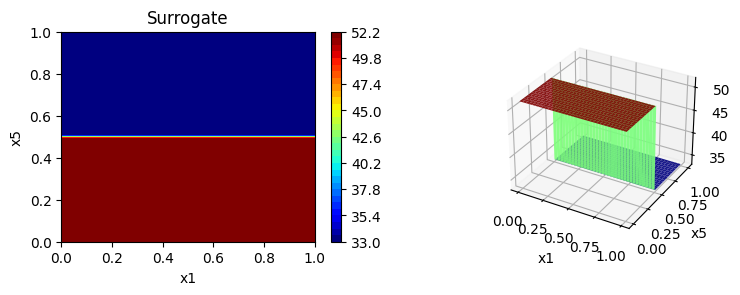

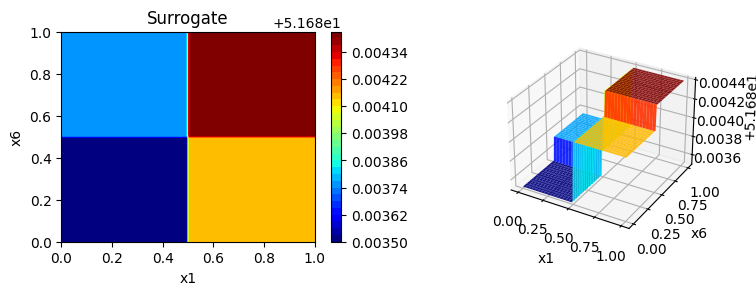

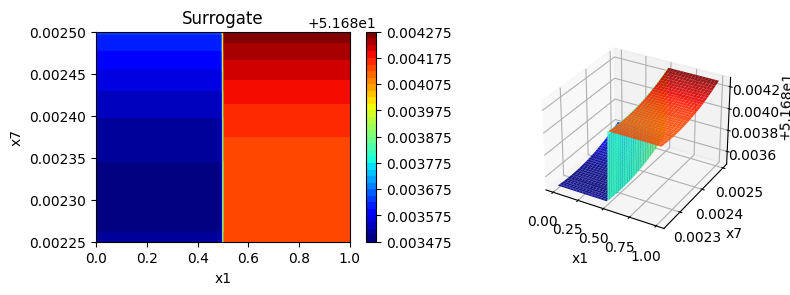

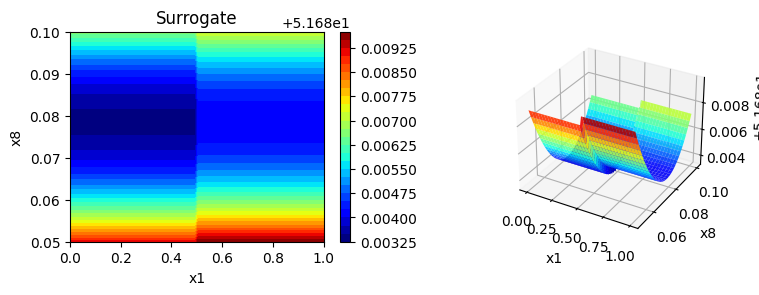

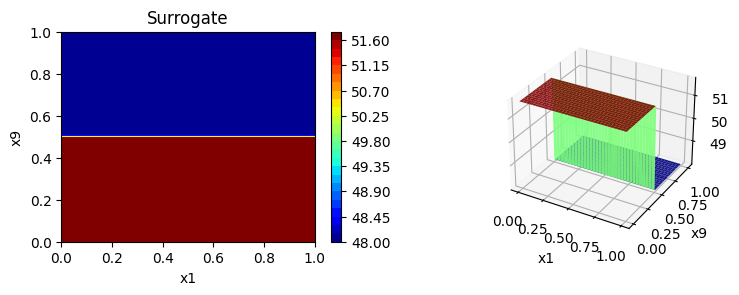

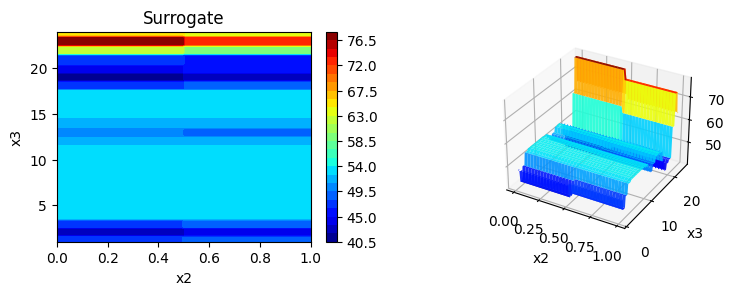

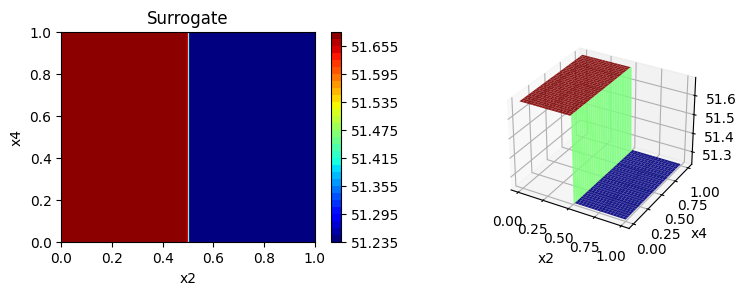

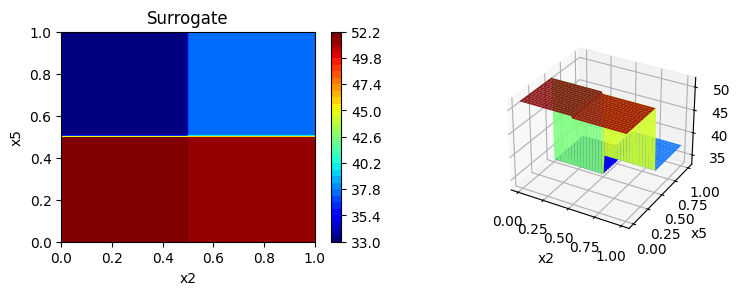

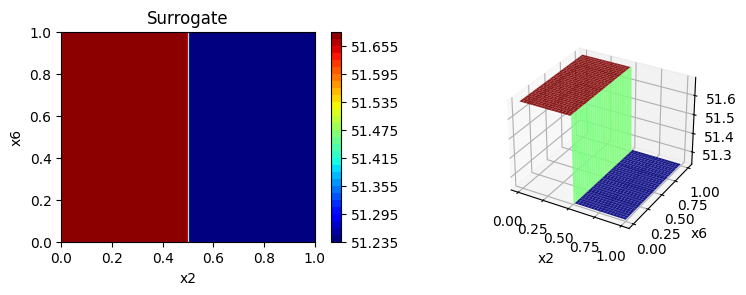

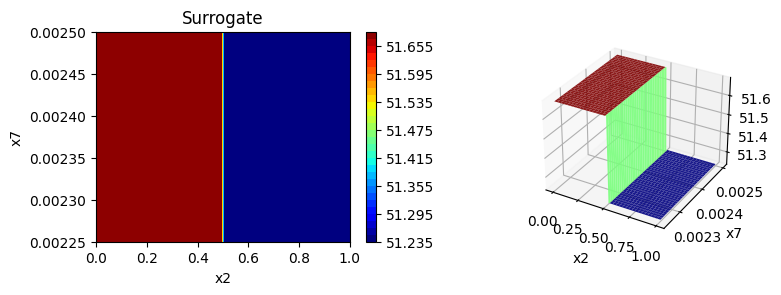

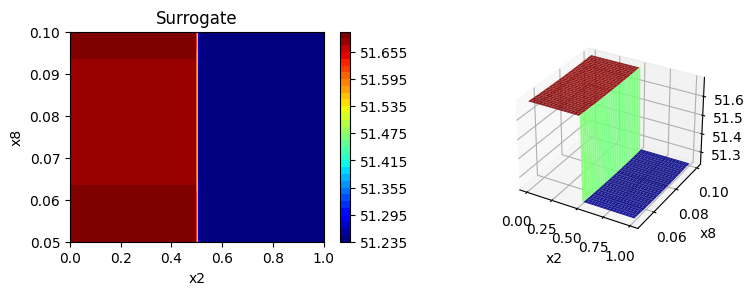

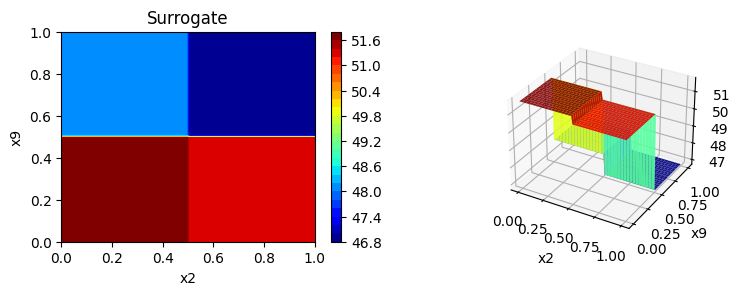

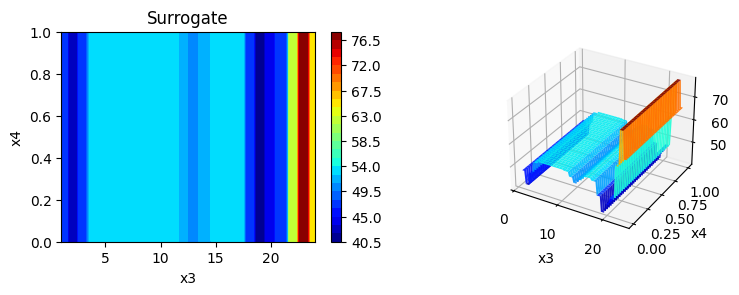

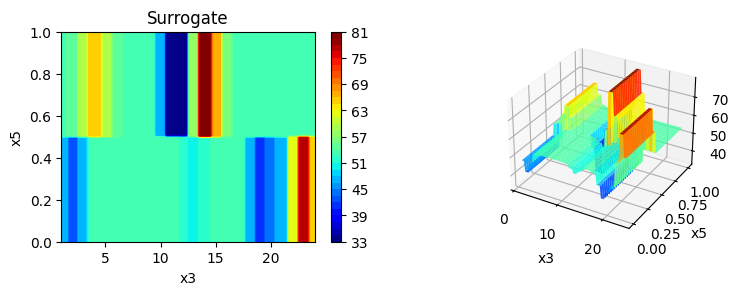

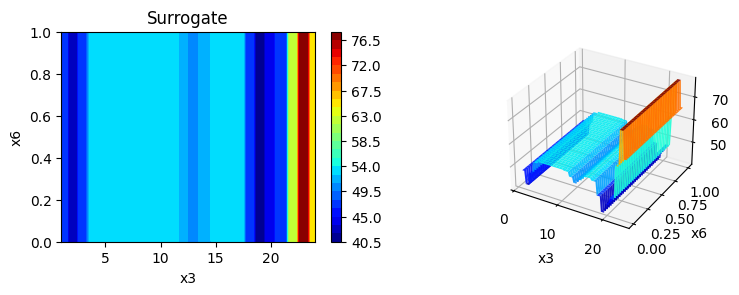

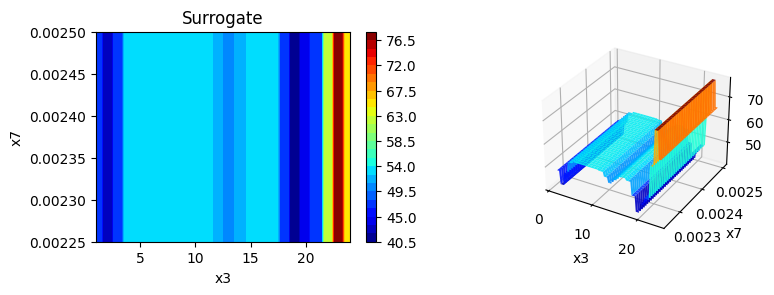

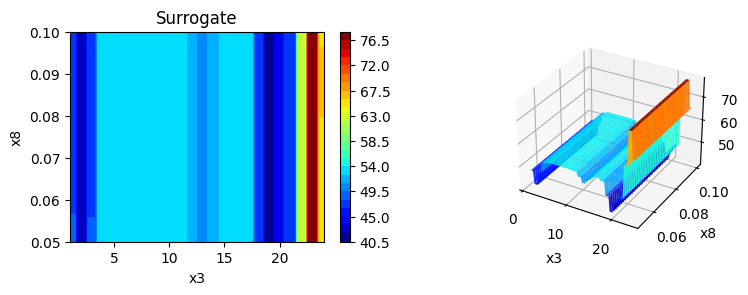

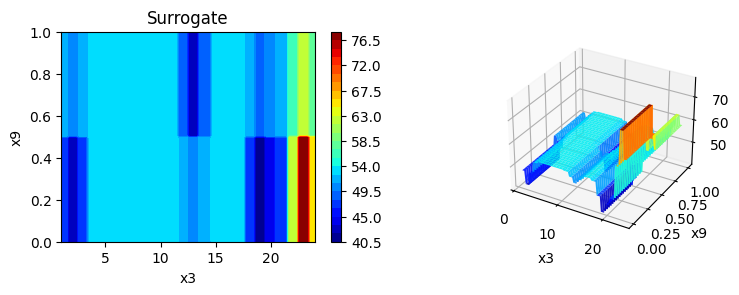

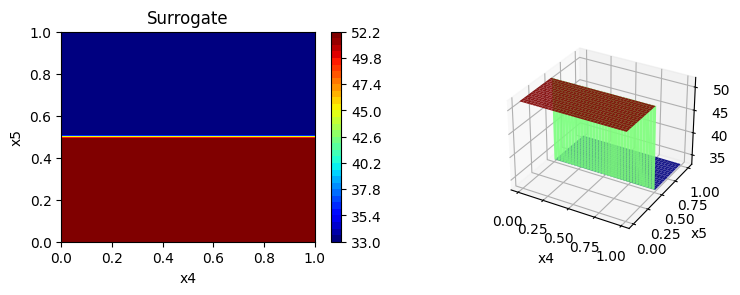

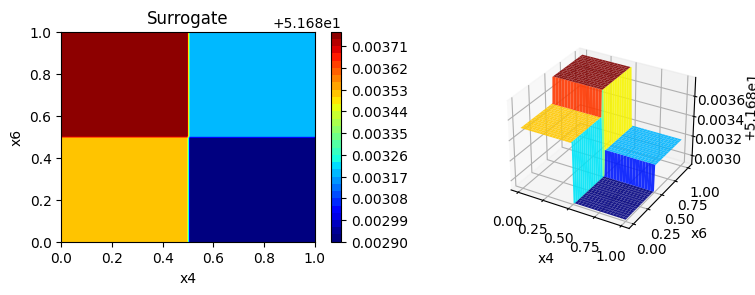

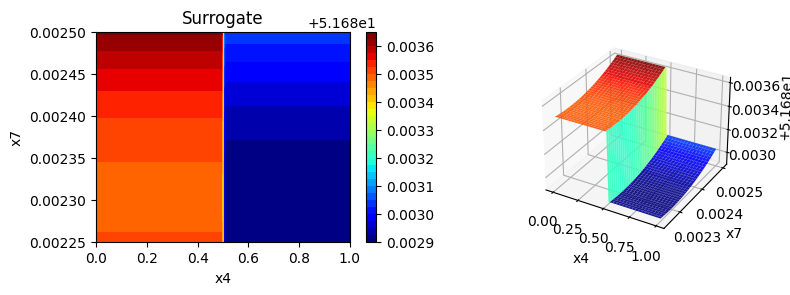

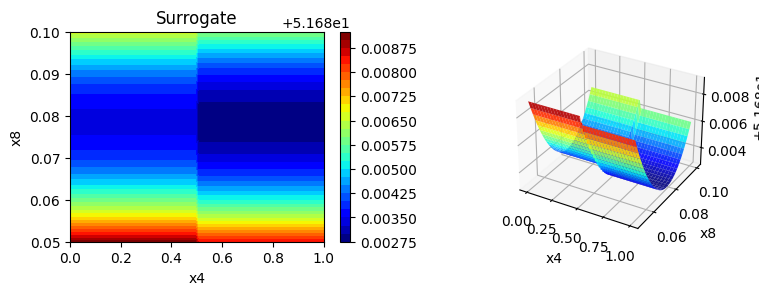

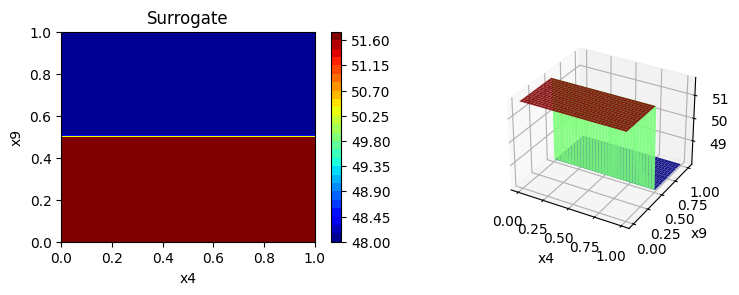

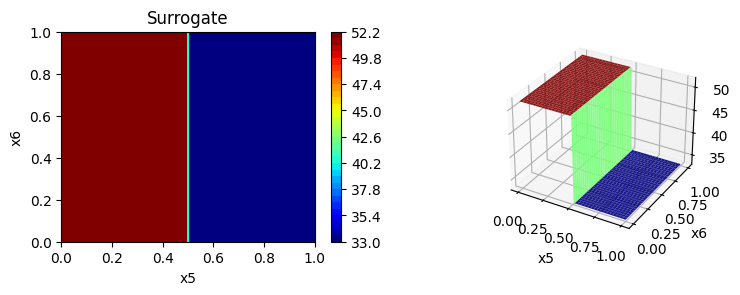

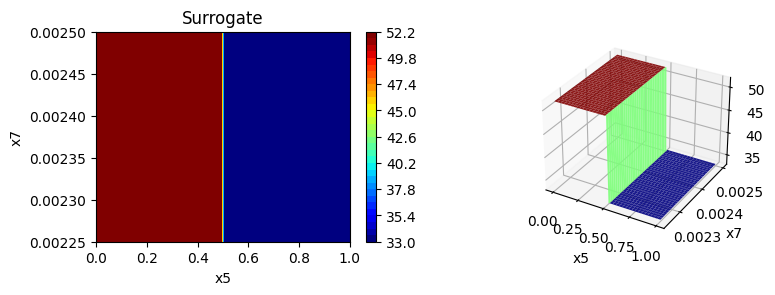

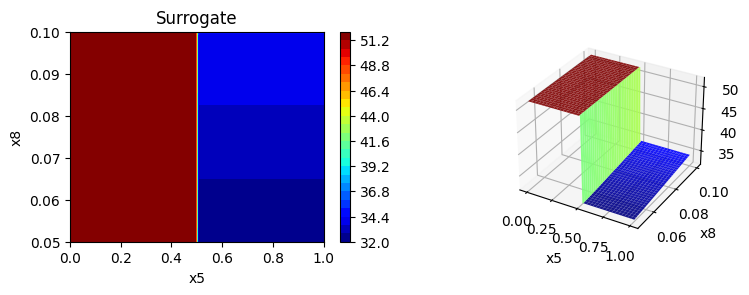

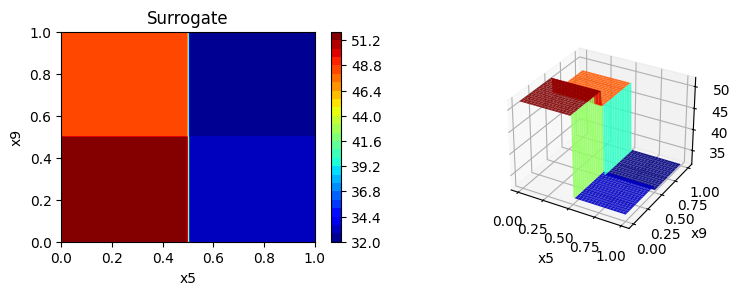

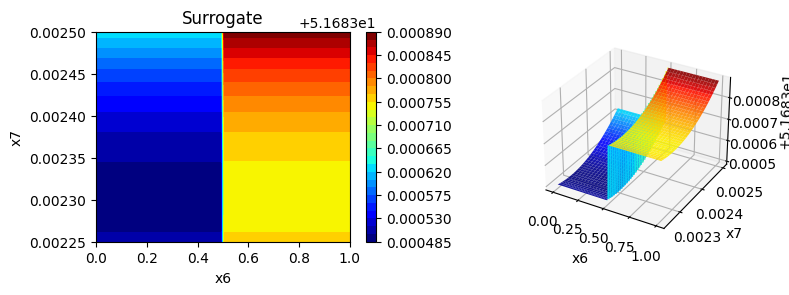

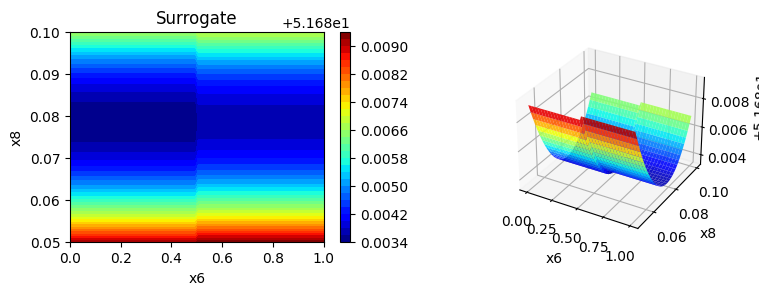

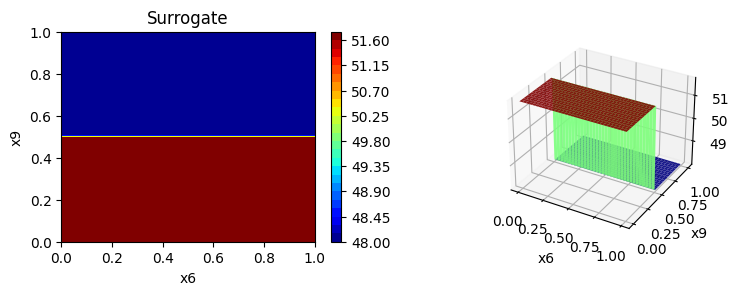

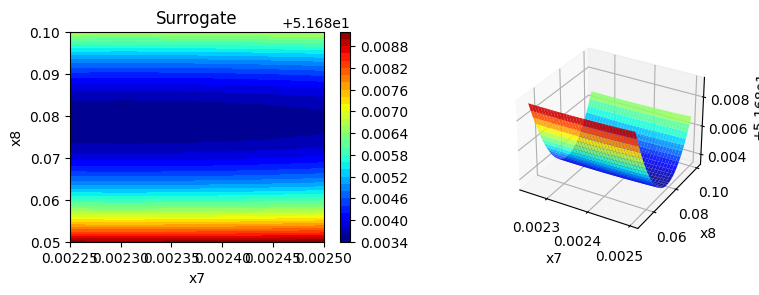

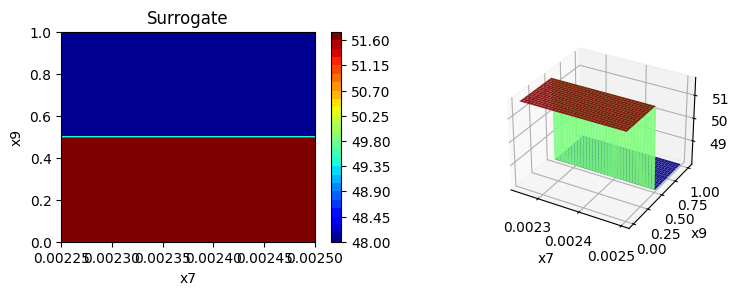

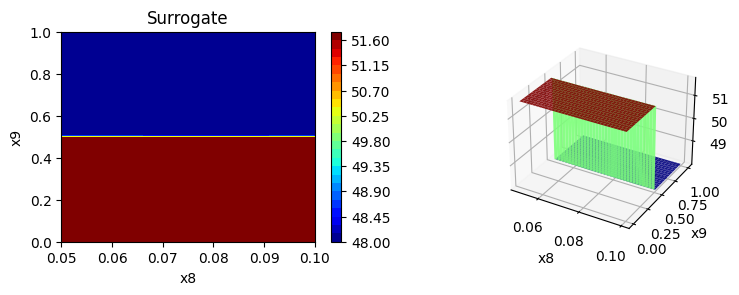

In [12]:
n = spot_snarimax.k
for i in range(n-1):
    for j in range(i+1, n):
        spot_snarimax.plot_contour(i=i, j=j)

## Build and Evaluate SNARIMAX Model with Tuned Hyperparameters

In [13]:
X = spot_snarimax.to_all_dim(spot_snarimax.min_X.reshape(1,-1))
p = X[:, 0]
d = X[:, 1]
q = X[:, 2]
m = X[:, 3]
sp = X[:, 4]
sd = X[:, 5]
sq = X[:, 6]
lr = X[:, 7]
intercept_lr = X[:, 8]
hour = X[:, 9]
weekday = X[:,10]
month = X[:,11]

In [14]:
from spotRiver.utils.features import get_weekday_distances
from spotRiver.utils.features import get_ordinal_date
from spotRiver.utils.features import get_month_distances
from spotRiver.utils.features import get_hour_distances
h_i = int(hour)
w_i = int(weekday)
m_i = int(month)
# baseline:
extract_features = compose.TransformerUnion(get_ordinal_date)
if h_i:
    extract_features = compose.TransformerUnion(get_ordinal_date,
                                                get_hour_distances)
if w_i:
    extract_features = compose.TransformerUnion(extract_features,
                                                get_weekday_distances)
if m_i:
    extract_features = compose.TransformerUnion(extract_features,
                                                get_month_distances)
    model = compose.Pipeline(
        ("extraction", extract_features),
        ("ts", time_series.SNARIMAX(
            p=int(p),
            d=int(d),
            q=int(q),
            m=int(m),
            sp=int(sp),
            sd=int(sd),
            sq=int(sq),
            regressor=compose.Pipeline(
                ("prep", preprocessing.StandardScaler()),
                ("lm", linear_model.LinearRegression(
                    intercept_init=0,
                    optimizer=optim.SGD(float(lr)),
                    intercept_lr=float(intercept_lr),
                )),
            ),
        )),
    )
else:  # wrong feature level
    raise ValueError(f"Value (level) of `feature`: {feat} is not in the range from 1 to 4.")
# eval
metric = metrics.MAE()
res = time_series.evaluate(fun_control["data"], model, metric, horizon=fun_control["horizon"])

In [15]:
y = res.metrics
z = 0.0
for j in range(len(y)):
    z = z + y[j].get()
z / len(y)

18.133995698734996

In [16]:
model

Pipeline (
  TransformerUnion (
    TransformerUnion (
      FuncTransformer (
        func="get_ordinal_date"
      )
    ),
    FuncTransformer (
      func="get_month_distances"
    )
  ),
  SNARIMAX (
    p=0
    d=0
    q=0
    m=11
    sp=0
    sd=1
    sq=1
    regressor=Pipeline (
      steps=OrderedDict([('prep', StandardScaler (
    with_std=True
  )), ('lm', LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.00225
      )
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0
    intercept_lr=Constant (
      learning_rate=0.089115
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  ))])
    )
  )
)

In [17]:
model["ts"].regressor["lm"].weights

{'January': -1.1103916003530458,
 'February': -4.183184680611067,
 'March': 0.007032480207300355,
 'April': -1.0404081303285253,
 'May': -5.084165885869312,
 'June': -3.107705403854752,
 'July': 3.640249450572474,
 'August': 8.543598558834486,
 'September': 6.624477970810573,
 'October': 2.3597874128915697,
 'November': -4.128020865291585,
 'December': -2.427990752788268,
 'ordinal_date': 0.813646549549737,
 'se-11': -0.11842779441829858}

In [18]:
forecast = model.forecast(horizon=fun_control["horizon"])
forecast


[392.7325976839078,
 456.3715380602646,
 446.5349266913963,
 470.7259364613879,
 522.7592548833111,
 598.5584432525127,
 609.1395954365312,
 513.4520788467031,
 457.40084824486144,
 412.6668305944097,
 455.5573694690206,
 443.3358214818144]